# Libraries

In [1]:
import sys
sys.path.append("./")
from utils import train_test_split, get_normal_weight

from tqdm.auto import tqdm 
tqdm.pandas()
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Preprocessing

In [2]:
DATA = "data/"

data = pd.read_csv(DATA + "fact_train_test.csv", sep=";")
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,"71,0",1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,"210,0",3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,"67,0",1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,"67,0",1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,"66,0",1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,"69,0",1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,"70,0",1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,"70,0",1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,"207,0",3


In [3]:
data["period"] = pd.to_datetime(data["period"])
data["real_weight"] = data["real_weight"].apply(lambda x: float(x.replace(",", ".")))
data = data[data["real_weight"] >= 0]
data = data.sort_values(by="period")
data.shape

(3559215, 11)

In [4]:
data = data[data["period"] > datetime.datetime(2017, 1, 1)]
data.shape

(3514465, 11)

# FE 

In [5]:
datetime_columns = ["period"]

In [6]:
def add_time_series_features(df, data_cols=['period']):
    features = []
    for col in datetime_columns:
        features.extend([col + "_year", col + "_day", col + "_weekday", col + "_month"])
        df[col] = df[col].fillna(df[col].mode())
        df[col] = pd.to_datetime(df[col], format="%Y-%m-%d",errors='coerce')
        df[col + "_year"] = df[col].dt.year
        df[col + "_day"] = df[col].dt.day
        df[col + "_weekday"] = df[col].dt.weekday
        df[col + "_month"] = df[col].dt.month
        df[col + "_seconds"] = df[col].apply(lambda x: (x - datetime.datetime(1970, 1, 1)).total_seconds())
    return df, features


def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    client_mapping_file = "./data/client_mapping.csv"
    freight_mapping_file = "./data/freight_mapping.csv"
    station_mapping_file = "./data/station_mapping.csv"
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


data, cat_datetime_fe = add_time_series_features(data)
data = add_master_data_mappings(data)
data["holding_name"] = data["holding_name"].fillna(-1).astype("int")

In [7]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,128.0,...,1,2,2,1.485907e+09,-1,39,36,4,54,4
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,68.0,...,1,2,2,1.485907e+09,-1,39,36,4,54,4
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,39.0,...,1,2,2,1.485907e+09,-1,39,36,4,104,10
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,62.0,...,1,2,2,1.485907e+09,-1,39,18,9,141,29
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,64.0,...,1,2,2,1.485907e+09,-1,39,36,4,134,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,194.0,...,1,2,3,1.677629e+09,519,39,79,10,2,12
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,65.0,...,1,2,3,1.677629e+09,519,39,79,10,4,12
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,659.0,...,1,2,3,1.677629e+09,519,39,79,10,76,6
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,66.0,...,1,2,3,1.677629e+09,519,14,79,10,8,16


In [8]:
binary_features = pd.read_csv(DATA + "binary_map.csv", index_col=0)
binary_features

,freight_id,client_sap_id,sender_station_id,recipient_station_id,sender_organisation_id,rps,filial,podrod,period_0,period_1,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,0,-1,1576,37851,0,1,2,5,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-1,1576,38902,0,1,2,5,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,-1,2977,38567,7152,0,2,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,-1,3801,26930,7152,0,2,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-1,3845,28207,8535,0,2,1,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025493,5086,-1,32475,32012,7667,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1025494,5086,-1,32475,32013,7667,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1025495,5086,-1,38832,34766,25860,1,1,5,False,False,...,False,False,False,False,False,False,False,False,True,False
1025496,5086,102,1916,31527,11906,0,1,2,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
data = data.merge(binary_features, how='left', on=['freight_id',
                                                   'client_sap_id',
                                                   'sender_station_id',
                                                   'recipient_station_id',
                                                   'sender_organisation_id',
                                                   'rps',
                                                   'filial',
                                                   'podrod'])

In [11]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,period_75_y,period_76_y,period_77_y,period_78_y,period_79_y,period_80_y,period_81_y,period_82_y,period_83_y,period_84_y
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,128.0,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,68.0,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,39.0,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,62.0,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,64.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,194.0,...,False,False,False,False,False,True,True,True,True,True
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,65.0,...,False,False,False,False,False,False,False,False,False,True
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,659.0,...,False,False,False,False,False,False,False,False,False,True
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,66.0,...,False,False,False,False,False,False,False,False,False,True


In [12]:
data.isnull().sum()

period           0
rps              0
podrod           0
filial           0
client_sap_id    0
                ..
period_80_y      0
period_81_y      0
period_82_y      0
period_83_y      0
period_84_y      0
Length: 192, dtype: int64

# Model

In [37]:
model = CatBoostRegressor(
    max_depth=6,
    random_state=42,
    task_type="GPU",
    loss_function="Poisson"
)

In [38]:
# train_test = train_test_split(data, group_columns=["rps", "holding_name", "sender_department_name", "recipient_department_name"])
# train, test = train_test[train_test["is_test"] == False], train_test[train_test["is_test"] == True]
# train, test = train.drop(columns=["is_test"]), test.drop(columns=["is_test"])
# train_test

In [39]:
data.shape

(3514465, 193)

In [40]:
test_dates = set(data["period"].unique()[-5:])
data["is_test"] = data["period"].progress_apply(lambda x: x in test_dates)
data["is_test"].sum(), data["is_test"].shape[0] - data["is_test"].sum()

  0%|          | 0/3514465 [00:00<?, ?it/s]

(218828, 3295637)

In [41]:
train, test = data[data["is_test"] == False], data[data["is_test"] == True]
train, test = train.drop(columns=["is_test"]), test.drop(columns=["is_test"])
train.shape, test.shape

((3295637, 192), (218828, 192))

In [42]:
train["real_wagon_count"].value_counts()

real_wagon_count
1       1214075
2        466763
3        247472
0        197586
4        164572
         ...   
5503          1
4971          1
2055          1
4548          1
2641          1
Name: count, Length: 3575, dtype: int64

In [43]:
train["real_wagon_count"].value_counts()

real_wagon_count
1       1214075
2        466763
3        247472
0        197586
4        164572
         ...   
5503          1
4971          1
2055          1
4548          1
2641          1
Name: count, Length: 3575, dtype: int64

In [44]:
train = train.drop(columns=["real_weight"])
test = test.drop(columns=["real_weight"])

In [45]:
X_train, X_test, y_train, y_test = train.drop(columns=["real_wagon_count"]), test.drop(columns=["real_wagon_count"]), train["real_wagon_count"], test["real_wagon_count"]
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(3295637, 218828, 3295637, 218828)

In [46]:
cat_datetime_fe

['period_year', 'period_day', 'period_weekday', 'period_month']

In [47]:
cat_features =["podrod", "filial", "client_sap_id", "freight_id", "sender_station_id", "recipient_station_id", "sender_organisation_id"] + \
cat_datetime_fe + \
['recipient_department_name', 'recipient_railway_name', 'sender_department_name', 'sender_railway_name', "freight_group_name", "holding_name"]


In [48]:
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    use_best_model=True
)

0:	learn: 0.7756649	test: 0.8582981	best: 0.8582981 (0)	total: 91.9ms	remaining: 1m 31s
1:	learn: 0.6646853	test: 0.7920427	best: 0.7920427 (1)	total: 196ms	remaining: 1m 38s
2:	learn: 0.4450371	test: 0.6613208	best: 0.6613208 (2)	total: 297ms	remaining: 1m 38s
3:	learn: 0.2410575	test: 0.5320051	best: 0.5320051 (3)	total: 397ms	remaining: 1m 38s
4:	learn: -0.5992830	test: 0.0131484	best: 0.0131484 (4)	total: 499ms	remaining: 1m 39s
5:	learn: -0.7855925	test: -0.1013974	best: -0.1013974 (5)	total: 605ms	remaining: 1m 40s
6:	learn: -1.1465720	test: -0.3253148	best: -0.3253148 (6)	total: 687ms	remaining: 1m 37s
7:	learn: -1.4971048	test: -0.5400748	best: -0.5400748 (7)	total: 775ms	remaining: 1m 36s
8:	learn: -1.8308582	test: -0.7497990	best: -0.7497990 (8)	total: 861ms	remaining: 1m 34s
9:	learn: -2.1491352	test: -0.9696324	best: -0.9696324 (9)	total: 959ms	remaining: 1m 34s
10:	learn: -2.7949161	test: -1.3972815	best: -1.3972815 (10)	total: 1.06s	remaining: 1m 35s
11:	learn: -3.3658668

In [49]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,freight_group_name,15.787872
1,freight_id,14.156263
2,recipient_station_id,11.647695
3,sender_station_id,8.010830
4,podrod,7.264728
...,...,...
185,period_12_y,0.000000
186,period_30_y,0.000000
187,period_32_y,0.000000
188,period_35_y,0.000000


In [50]:
import numpy as np
preds = model.predict(X_test)
preds[preds < 0] = 0
preds

array([2.82110115, 6.01168251, 4.44727617, ..., 2.74745766, 1.78177335,
       2.52533392])

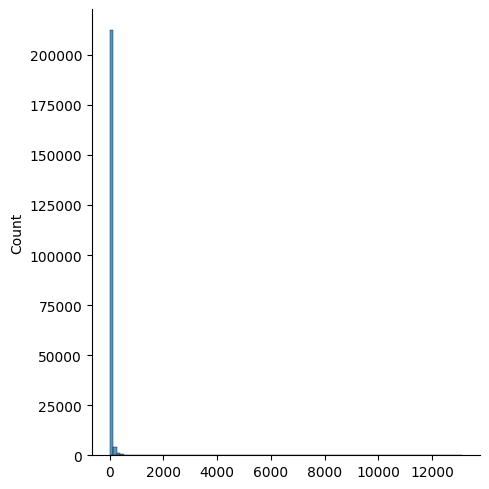

In [51]:
sns.displot(preds, bins=100)

In [52]:
X_test.shape[0], preds[preds < 0].shape,  preds[preds > 0].shape

(218828, (0,), (218828,))

In [53]:
X_test

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75_y,period_76_y,period_77_y,period_78_y,period_79_y,period_80_y,period_81_y,period_82_y,period_83_y,period_84_y
3295637,2022-11-01,1,5,1,-1,1078,9118,13385,29814,2022,...,False,True,True,False,False,True,False,False,False,False
3295638,2022-11-01,1,5,1,-1,1078,9118,28149,29814,2022,...,False,False,False,False,False,True,False,False,False,False
3295639,2022-11-01,1,5,1,-1,1078,10863,28862,31858,2022,...,False,False,True,True,True,True,False,False,False,False
3295640,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2022,...,False,False,False,False,True,True,False,False,False,False
3295641,2022-11-01,1,5,1,-1,1074,33741,9170,26007,2022,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,2023,...,False,False,False,False,False,True,True,True,True,True
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,False,False,False,False,False,False,False,False,False,True
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,2023,...,False,False,False,False,False,False,False,False,False,True
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,False,False,False,False,False,False,False,False,False,True


# Evaluate

In [31]:
import numpy as np


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    # fact = add_master_data_mappings(fact)
    # forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)

In [32]:
preds

array([1.01101761, 1.19221196, 0.99798448, ..., 0.99841245, 1.03514108,
       1.1412657 ])

In [33]:
fact = X_test.copy()
fact["real_wagon_count"] = y_test
fact = fact[fact["real_wagon_count"] > 0]

forecast = X_test.copy()
forecast["forecast_wagon_count"] = preds
forecast = forecast[forecast["forecast_wagon_count"] > 0]

In [34]:
forecast

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_76_y,period_77_y,period_78_y,period_79_y,period_80_y,period_81_y,period_82_y,period_83_y,period_84_y,forecast_wagon_count
3295637,2022-11-01,1,5,1,-1,1078,9118,13385,29814,2022,...,True,True,False,False,True,False,False,False,False,1.011018
3295638,2022-11-01,1,5,1,-1,1078,9118,28149,29814,2022,...,False,False,False,False,True,False,False,False,False,1.192212
3295639,2022-11-01,1,5,1,-1,1078,10863,28862,31858,2022,...,False,True,True,True,True,False,False,False,False,0.997984
3295640,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2022,...,False,False,False,True,True,False,False,False,False,1.004388
3295641,2022-11-01,1,5,1,-1,1074,33741,9170,26007,2022,...,True,True,True,True,True,True,True,True,True,1.031047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,2023,...,False,False,False,False,True,True,True,True,True,1.001285
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,False,False,False,False,False,False,False,False,True,1.002193
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,2023,...,False,False,False,False,False,False,False,False,True,0.998412
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,False,False,False,False,False,False,False,False,True,1.035141


In [36]:
# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")

Public score: 0.05124382663580529
Private score: 0.050683524254300893


С отрицательными значениями: 
Public score: 0.6031490080789712
Private score: 0.41790083598674166

Предикты меньше 0 заменить 0
Public score: 0.6159311265690937
Private score: 0.562187435265229

Все записи, где 0 дропнуть
Public score: 0.6159311265690937
Private score: 0.562187435265229

Фичи с весом 1 вагона:
Public score: 0.6140041549902395
Private score: 0.557186562527978

# Final Model

In [71]:
X, y = data.drop(columns=["real_wagon_count", "is_test", "real_weight"]), data["real_wagon_count"]
X

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2017-02-01,1,5,1,-1,1682,12676,12195,5244,2017,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,35462,5244,2017,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,38063,33596,9075,2017,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,12676,28542,3464,2017,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,38063,29125,9075,2017,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582275,2023-03-01,0,2,2,2129,1776,9390,32810,30685,2023,...,False,False,False,False,False,True,True,True,True,True
1582276,2023-03-01,0,2,2,2129,1697,35809,30790,25817,2023,...,False,False,False,False,False,False,False,False,False,True
1582277,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,False,False,False,False,False,False,False,False,False,True
1582278,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,False,False,False,False,False,False,False,False,False,True


In [73]:
params = model.get_all_params()
params["iterations"] = params["iterations"] + 100

In [74]:
new_params = {
    "iterations": params["iterations"],
    "depth":params["depth"],
    "learning_rate":params["learning_rate"],
    "random_seed":params["random_seed"],
    "task_type": params["task_type"],
}
new_params

{'iterations': 1100,
 'depth': 6,
 'learning_rate': 0.13665199279785156,
 'random_seed': 42,
 'task_type': 'GPU'}

In [75]:
final_model = CatBoostRegressor(
    **new_params
)

In [76]:
final_model.fit(
    X,
    y,
    cat_features=cat_features)

0:	learn: 4.7362205	total: 48.8ms	remaining: 53.6s
1:	learn: 4.5863826	total: 97.4ms	remaining: 53.5s
2:	learn: 4.3920621	total: 141ms	remaining: 51.5s
3:	learn: 4.2824910	total: 181ms	remaining: 49.7s
4:	learn: 4.1812075	total: 224ms	remaining: 49.1s
5:	learn: 4.0375153	total: 271ms	remaining: 49.4s
6:	learn: 3.8828882	total: 314ms	remaining: 49s
7:	learn: 3.8167875	total: 354ms	remaining: 48.3s
8:	learn: 3.8129511	total: 385ms	remaining: 46.6s
9:	learn: 3.6947682	total: 432ms	remaining: 47.1s
10:	learn: 3.6216259	total: 475ms	remaining: 47.1s
11:	learn: 3.6172809	total: 509ms	remaining: 46.2s
12:	learn: 3.6159952	total: 542ms	remaining: 45.4s
13:	learn: 3.5774865	total: 589ms	remaining: 45.7s
14:	learn: 3.5253241	total: 633ms	remaining: 45.8s
15:	learn: 3.4691365	total: 681ms	remaining: 46.2s
16:	learn: 3.4681094	total: 717ms	remaining: 45.7s
17:	learn: 3.3989862	total: 767ms	remaining: 46.1s
18:	learn: 3.3051090	total: 814ms	remaining: 46.3s
19:	learn: 3.2542908	total: 863ms	remaini

In [77]:
forecast_example = pd.read_csv(DATA + "forecast_example.csv", sep=";").drop(columns=["forecast_wagon_count"])
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,"73,0"
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,"146,0"
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,"876,0"
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,"473,0"
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,"63,0"
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,"69,0"
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,"70,0"
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,"70,0"
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,"207,0"


In [78]:
forecast_example["period"] = pd.to_datetime(forecast_example["period"])

forecast_example.shape

(239605, 10)

In [79]:
forecast_example, cat_datetime_fe = add_time_series_features(forecast_example)
forecast_example = add_master_data_mappings(forecast_example)
forecast_example["holding_name"] = forecast_example["holding_name"].fillna(-1).astype("int")

In [80]:
X_train

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2017-02-01,1,5,1,-1,1682,12676,12195,5244,2017,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,35462,5244,2017,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,38063,33596,9075,2017,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,12676,28542,3464,2017,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,38063,29125,9075,2017,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483607,2022-10-01,0,2,1,837,1041,33901,11223,26544,2022,...,False,True,False,False,True,False,False,False,False,False
1483608,2022-10-01,0,2,1,837,1041,33901,11195,26544,2022,...,False,True,False,True,True,True,False,False,True,True
1483609,2022-10-01,0,2,1,837,1041,33901,34208,26544,2022,...,True,True,True,True,True,True,True,False,False,True
1483610,2022-10-01,0,2,1,866,349,37358,38966,29645,2022,...,False,False,False,False,True,False,False,False,False,False


In [81]:
X.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'period_year',
       ...
       'period_75', 'period_76', 'period_77', 'period_78', 'period_79',
       'period_80', 'period_81', 'period_82', 'period_83', 'period_84'],
      dtype='object', length=105)

In [82]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'period_year', 'period_day', 'period_weekday',
       'period_month', 'period_seconds', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name'],
      dtype='object')

In [83]:
forecast_example = forecast_example.merge(binary_features, how='left', on=['freight_id',
                                                   'client_sap_id',
                                                   'sender_station_id',
                                                   'recipient_station_id',
                                                   'sender_organisation_id',
                                                   'rps',
                                                   'filial',
                                                   'podrod'])

In [85]:
forecast_example = forecast_example[X.columns]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,2023,...,False,False,False,False,False,False,False,False,True,True
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,2023,...,False,False,False,False,False,False,False,False,True,True
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,2023,...,False,False,False,False,False,False,False,False,True,True
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,2023,...,False,False,True,True,True,True,True,True,True,True
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,2023,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,2023,...,False,False,False,False,False,False,False,False,False,True
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,2023,...,False,True,False,False,True,True,True,False,False,True
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,2023,...,True,True,True,True,False,True,True,False,False,True
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,2023,...,False,False,True,True,True,True,True,False,False,True


In [86]:
final_preds = final_model.predict(forecast_example)
final_preds[final_preds < 0 ] = 0

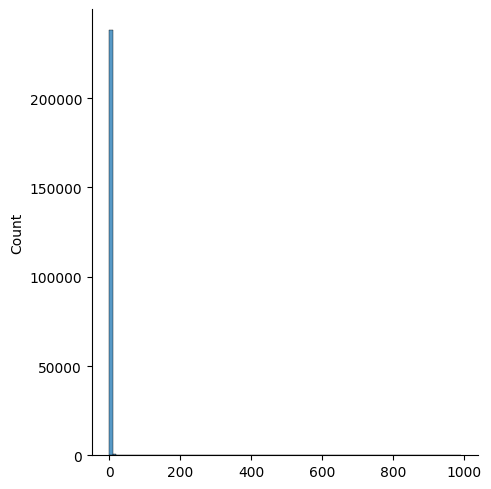

In [87]:
sns.displot(final_preds, bins=100)

In [88]:
pd.read_csv(DATA + "forecast_example.csv", sep=";").columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'forecast_wagon_count'],
      dtype='object')

In [89]:
NEEDED_COLUMNS = ['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id', 'forecast_wagon_count']

In [90]:
forecast_example["forecast_wagon_count"] = final_preds
forecast_example = forecast_example[NEEDED_COLUMNS]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,0.917622
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,0.906380
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,1.013182
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,1.147830
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,0.780555
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,1.666215
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,0.259127
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,0.691291
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,5.077725


In [91]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_wagon_count'],
      dtype='object')

In [92]:
forecast_example.to_csv("submission_drop_outliers_regressor_228.csv", index=False, sep=";", decimal=",", encoding="windows-1251")